In [1]:
import numpy as np
import pandas as pd
import pymongo
import tensorflow as tf

In [2]:
#从数据库中读取数据
client=pymongo.MongoClient('localhost',27017)#连接数据库
db1=client['douban']#创建新数据库
pred_comments=db1['pred_comments']
data = pd.DataFrame(list(pred_comments.find()))

In [3]:
word_vectors=np.load('sample_Tencent_AILab_ChineseEmbedding.npy',allow_pickle=True).item()
#转换词向量
def convert_to_vec(words_list):
    words_vec=[]
    for i in words_list:
        if i in word_vectors:
            words_vec.append(np.array(word_vectors[i]))
    return np.array(words_vec)
#获取每个评论词向量的数量
def get_seq_length(data):
    return len(data)
# 转换评星
def convert_stars(star):
    if int(star)>3:
        return 1
    else:
        return 0

data['word_vec']=data.processed_comment.apply(convert_to_vec)
data['pos1neg0']=data.star.apply(convert_stars)
data['seq_length']=data.word_vec.apply(get_seq_length)
data=data[[list(i)!=[] for i in data['word_vec']]]#删除词向量为[]的文本
data.head(2)

,_id,content,processed_comment,star,word_vec,pos1neg0,seq_length
0,5cdbd2cda1cf18259c85b40e,当然算不上杰作，但放豆瓣语境下，是部时至今日终于拍出来的国产“高分韩国电影”。拿现实题材拍商...,"[算不上, 杰作, 但放, 豆瓣, 语境, 时至今日, 终于, 国产, 高分, 韩国, 电影...",4,"[[0.192524, -0.185849, 0.275798, 0.053039, 0.5...",1,27
1,5cdbd2cda1cf18259c85b40f,最大的病，其实是穷病。真的被感动了，整体都很成熟，也有些许韩片的影子。几个演员表演都非常出色...,"[最大, 其实, 穷病, 真的, 感动, 整体, 成熟, 些许, 韩片, 影子, 几个, 演...",4,"[[-0.026906, 0.003273, 0.084483, 0.253033, 0.0...",1,30


In [4]:
num2=np.mean(data[:].processed_comment.apply(lambda x:len(x)))
num1=np.mean(data[:].word_vec.apply(lambda x:len(x)))

print('平均每个评论有',num2,'个词')
print('平均每个评论有',num1,'个 wordvec')

平均每个评论有 17.11447859982942 个词
平均每个评论有 16.523874734224655 个 wordvec


In [5]:
#下采样
negdata=data[~data['pos1neg0'].isin([1])]
posdata=data[~data['pos1neg0'].isin([0])]
xiacaiyangpos=posdata.sample(frac=0.25,replace=False)
newdata=pd.concat( [negdata,xiacaiyangpos], axis=0 ) 
data=newdata

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
X=tfidf.fit_transform(data.processed_comment.apply(lambda x:' '.join(x)))
y=data['pos1neg0']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [7]:
X

<30485x64128 sparse matrix of type '<class 'numpy.float64'>'
	with 484952 stored elements in Compressed Sparse Row format>

In [8]:
#5 选择模型
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import time
from sklearn.externals import joblib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

lr=LogisticRegression()
by=GaussianNB()
sgd=SGDClassifier()
svc=SVC()
tree=DecisionTreeClassifier()
forest=RandomForestClassifier()
# gb=GradientBoostingClassifier()
# xgb=XGBClassifier()

D:\Program\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


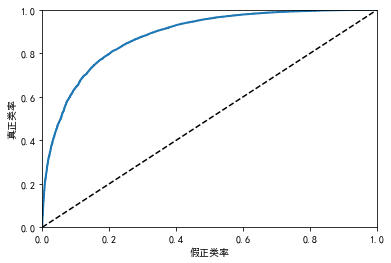

0.8820029984867312

In [9]:
estimator=lr

#画roc曲线
y_train_score=cross_val_predict(estimator,X_train,y_train,cv=3,method='decision_function')
fpr,tpr,thresholds=roc_curve(y_train,y_train_score)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=None)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('假正类率')
    plt.ylabel('真正类率')
plot_roc_curve(fpr,tpr)
plt.show()
roc_auc_score(y_train,y_train_score)

In [14]:
estimator=LogisticRegression(C=0.01)

#交叉验证求roc score
cross_val=cross_validate(estimator,X_train[0:1000].toarray(),y_train[0:1000],scoring='accuracy',cv=5,return_train_score=True)
fit_time=cross_val['fit_time']
train_scores=cross_val['train_score']
test_scores=cross_val['test_score']
print('训练用时：',fit_time.sum(),'s')
print('训练集ROC：  ',train_scores.mean(),' +-','训练集std： ',train_scores.std())
print('验证集ROC：  ',test_scores.mean(),' +-','验证集std： ',test_scores.std())

D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

训练用时： 1.607668161392212 s
训练集ROC：   0.58  +- 训练集std：  0.0
验证集ROC：   0.58  +- 验证集std：  0.0


In [15]:
estimator=lr

#7 训练与保存模型
estimator.fit(X_train,y_train)
y_train_pre=estimator.predict(X_train)
y_test_pre=estimator.predict(X_test)


from sklearn.metrics import confusion_matrix
print('训练集: \n',confusion_matrix(y_train,y_train_pre))
print('测试集: \n',confusion_matrix(y_test,y_test_pre))

训练集: 
 [[ 8618  1775]
 [  632 13363]]
测试集: 
 [[1697  807]
 [ 373 3220]]


D:\Program\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
